In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm 

DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu'

%matplotlib inline

In [2]:
class Encoder(nn.Module):
    """The encoder for VAE"""
    
    def __init__(self, input_dim, fc_dim, latent_dim):
        super().__init__()
        
        self.fwd = nn.Sequential(
            nn.Linear(input_dim, fc_dim),
            nn.ReLU(),
            nn.Linear(fc_dim, fc_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(fc_dim, latent_dim)
        self.fc_log_var = nn.Linear(fc_dim, latent_dim)
                    
    def forward(self, x):
        x = self.fwd(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var
    
class Decoder(nn.Module):
    """The decoder for VAE"""
    
    def __init__(self, latent_dim, fc_dim, output_dim):
        super().__init__()

        self.fwd = nn.Sequential(
            nn.Linear(latent_dim, fc_dim),
            nn.ReLU(),
            nn.Linear(fc_dim, fc_dim),
            nn.ReLU(),
            nn.Linear(fc_dim, output_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.fwd(x)

In [3]:
class VAE(nn.Module):
    """VAE"""
    
    def __init__(self, input_dim, fc_dim, latent_dim):
        super().__init__()
        
        self.encoder = Encoder(input_dim, fc_dim, latent_dim).to(DEVICE)
        self.decoder = Decoder(latent_dim, fc_dim, input_dim).to(DEVICE)
        
    def sample_z(self, mu, log_var):
        """sample z by reparameterization trick"""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    def sample_z_uniform(self, centre, widths) :
        temp = torch.rand_like(centre) - 0.5 # centred at origin 
        return torch.exp(widths)*2*temp + centre
    
    def forward(self, x, point=False, uniform=False):
        mu, log_var = self.encoder(x)
        if point : z = mu 
        elif uniform : z = self.sample_z_uniform(mu, log_var)
        else : z = self.sample_z(mu, log_var).to(DEVICE)
        recon = self.decoder(z)
        return recon, mu, log_var
    
    def compute_loss(self, x, recon, mu, log_var):
        """compute loss of VAE"""
        
        # KL loss
        kl_loss = (0.5*(log_var.exp() + mu ** 2 - 1 - log_var)).sum(1).mean()
        
        # recon loss
        
        recon_loss = F.binary_cross_entropy(recon, x, reduction="none").sum([1]).mean()
        
        return kl_loss, recon_loss, recon, x

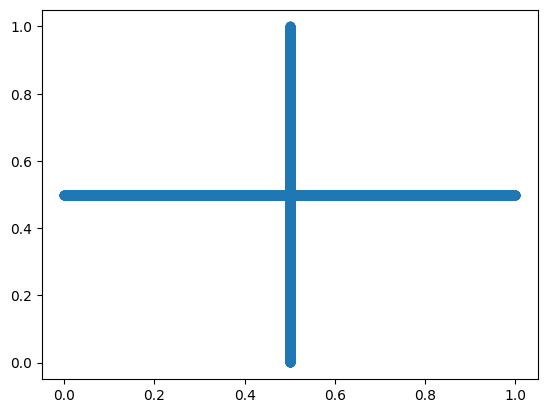

In [4]:
num_points = 10000
filter = lambda x : x # if x>0.55 or x<0.45 else 0.5 + (x>0)*0.05
X1 = [0.5]*num_points
Y1 = [filter(x) for x in torch.rand(num_points)]
X2 = [filter(x) for x in torch.rand(num_points)]
Y2 = [0.5]*num_points
data1 = [(x,y) for x,y in zip(X1,Y1)]
data2 = [(x,y) for x,y in zip(X2,Y2)]
cross_data = data1 + data2

plt.scatter([i[0] for i in cross_data], [i[1] for i in cross_data])

In [5]:
class cross_dataset(torch.utils.data.Dataset) :
    def __init__(self, arr, transforms=None, subset=0) :
        self.arr = arr
        self.transforms = transforms
        if subset>0 : self.arr = self.arr[:subset]
    def __len__(self) :
        return len(self.arr)
    def __getitem__(self, idx) :
        Data = self.arr[idx]
        if self.transforms :
            Data = self.transforms(Data)
        return torch.tensor(Data)


In [6]:
input_dim = 2
fc_dim = 15
latent_dim = 2 # same as the original dim

epochs = 4000

device = DEVICE
print(f'{device=}')

# transform=transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=0, std=4.)
# ])

dataset = cross_dataset(cross_data)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
# test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

model = VAE(input_dim, fc_dim, latent_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

print('params', sum([p.numel() for p in model.parameters()]))

device='cuda:1'
params 666


In [9]:
losslog = []
recons = []
xs = []
for epoch in tqdm(range(epochs)):
    for i, (images) in enumerate(train_loader):
        images = images.to(DEVICE)
        recon, mu, log_var = model(images)
        loss1, loss2, recon, x = model.compute_loss(images, recon, mu, log_var)
        with torch.no_grad() : recons.append(recon.detach()); xs.append(x.detach())
        loss = 0.1*loss1 + loss2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad() : losslog.append(loss.item())
    if epoch%300==0 : 
        tqdm.write(f'Epoch {epoch}, loss1 {loss1.item()}, loss2 {loss2.item()}')

# optimizer.param_groups[0]['lr'] /= 10
# for epoch in tqdm(range(1200)):
#     for i, (images) in enumerate(train_loader):
#         images = images.to(DEVICE)
#         recon, mu, log_var = model(images)
#         loss = model.compute_loss(images, recon, mu, log_var)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         with torch.no_grad() : losslog.append(loss.item())
#     if epoch%1==0 : 
#         tqdm.write(f'Epoch {epoch}, loss {loss.item()}')

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch 0, loss1 0.8063622713088989, loss2 1.2793421745300293
Epoch 300, loss1 0.8073190450668335, loss2 1.279512882232666
Epoch 600, loss1 0.8003044128417969, loss2 1.2795162200927734
Epoch 900, loss1 0.803341805934906, loss2 1.279356598854065
Epoch 1200, loss1 0.8011198043823242, loss2 1.2798112630844116
Epoch 1500, loss1 0.8070335984230042, loss2 1.2795988321304321
Epoch 1800, loss1 0.8032656311988831, loss2 1.280043125152588
Epoch 2100, loss1 0.8042632937431335, loss2 1.2797755002975464
Epoch 2400, loss1 0.8031401634216309, loss2 1.2804944515228271
Epoch 2700, loss1 0.8014104962348938, loss2 1.2788201570510864
Epoch 3000, loss1 0.8097279071807861, loss2 1.2804030179977417
Epoch 3300, loss1 0.8113477826118469, loss2 1.2783937454223633
Epoch 3600, loss1 0.8082134127616882, loss2 1.2796789407730103
Epoch 3900, loss1 0.8060711622238159, loss2 1.280312418937683


In [10]:
recons[0].shape, xs[0].shape

(torch.Size([20000, 2]), torch.Size([20000, 2]))

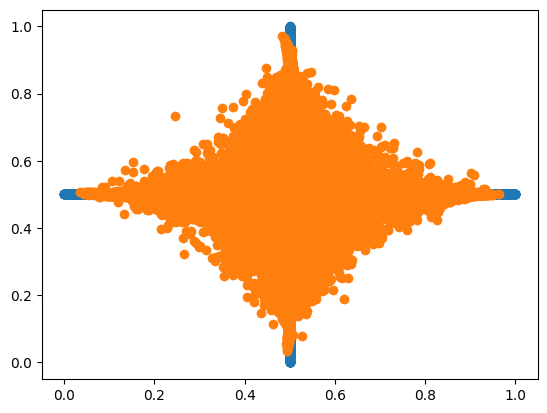

In [11]:
plt.scatter(xs[0].cpu()[:,0], xs[0].cpu()[:,1])
plt.scatter(recons[-1].cpu()[:,0], recons[-1].cpu()[:,1])

In [12]:
## generate new images by VAE
sample_zs = torch.randn(500, latent_dim).to('cuda:1')
model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs)
    generated_imgs = generated_imgs.cpu().numpy()
generated_imgs = np.array(generated_imgs)

(0.0, 1.0)

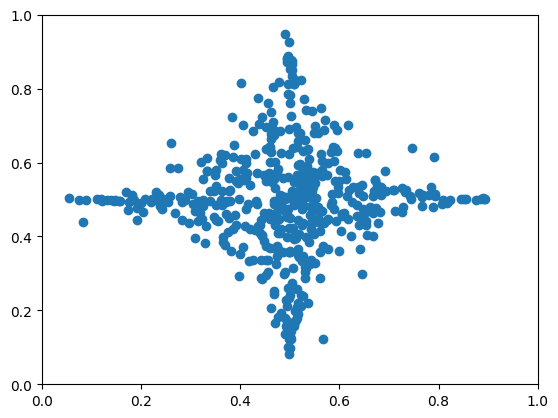

In [14]:
plt.scatter(generated_imgs[:,0], generated_imgs[:,1])
plt.xlim(0.,1.)
plt.ylim(0.,1.)

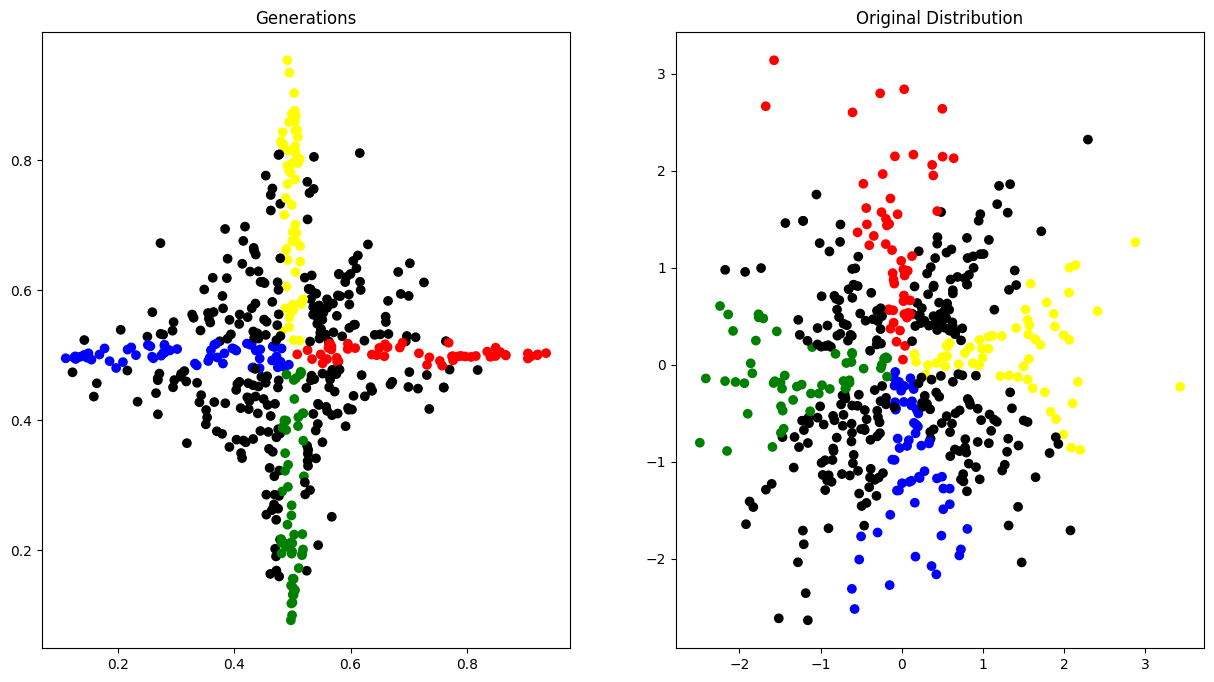

In [19]:
def color(x, y) : 
    if abs(y-0.5)<0.02 and x>0.5 : return 'red'
    if abs(y-0.5)<0.02 and x<0.5 : return 'blue'
    if abs(x-0.5)<0.02 and y>0.5 : return 'yellow'
    if abs(x-0.5)<0.02 and y<0.5 : return 'green'
    return 'black'
    

## generate new images by VAE
sample_zs = torch.randn(500, latent_dim).to('cuda:1')
model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs)
    generated_imgs = generated_imgs.cpu().numpy()
generated_imgs = np.array(generated_imgs)

colors = [color(x,y) for (x,y) in generated_imgs]

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.title('Generations')
plt.scatter(x=[i[0] for i in generated_imgs], y=[i[1] for i in generated_imgs], c=colors)
# plt.scatter([i[0] for i in data], [i[1] for i in data], c='green', marker='.')
plt.subplot(1,2,2)
plt.title('Original Distribution')
plt.scatter(x=[i[0] for i in sample_zs.cpu()], y=[i[1] for i in sample_zs.cpu()], c=colors)

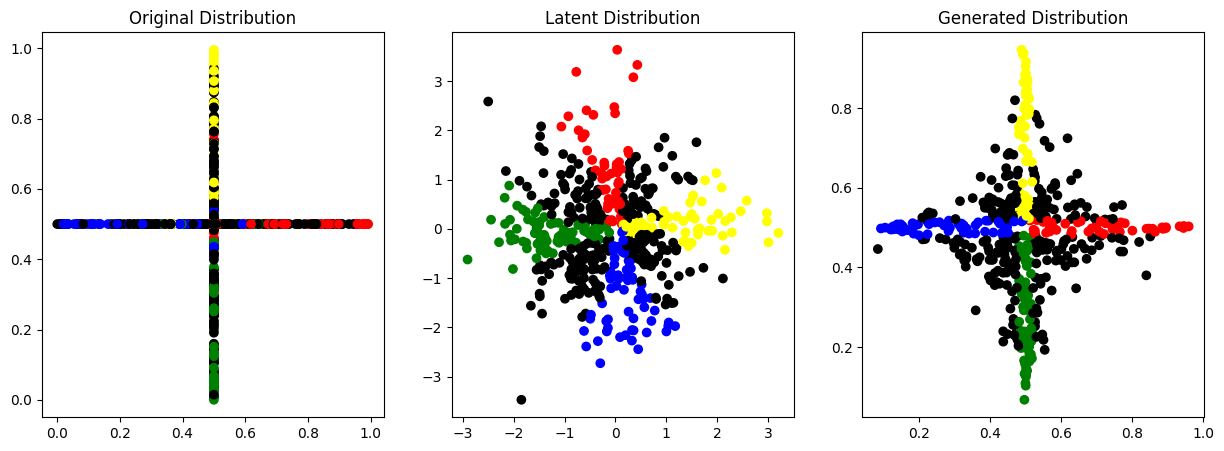

In [41]:
original = next(iter(train_loader))
mu, var = model.encoder(original.cuda(1))
latent = model.sample_z(mu, var)
generations = model.decoder(latent)

latent = latent.cpu().detach()
generations = generations.cpu().detach()

colors = [color(x,y) for (x,y) in generations[::40]]

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Original Distribution')
plt.scatter(x=[i[0] for i in original[::40]], y=[i[1] for i in original[::40]], c=colors)
plt.subplot(1,3,2)
plt.title('Latent Distribution')
plt.scatter(x=[i[0] for i in latent[::40]], y=[i[1] for i in latent[::40]], c=colors)
plt.subplot(1,3,3)
plt.title('Generated Distribution')
plt.scatter(x=[i[0] for i in generations[::40]], y=[i[1] for i in generations[::40]], c=colors)

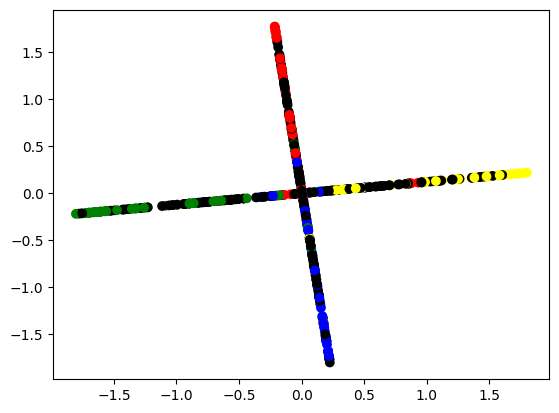

In [60]:
plt.scatter(mu.cpu().detach()[::40,0], mu.cpu().detach()[::40,1], c=colors)

In [136]:
log_var

tensor([[0.3692, 0.3571],
        [0.4047, 0.3478],
        [0.3969, 0.3821],
        ...,
        [0.4001, 0.3846],
        [0.3654, 0.3799],
        [0.4143, 0.4002]], device='cuda:1', grad_fn=<AddmmBackward0>)

In [50]:
options = ['green','blue','red','yellow']
means = [generations[::40][np.array(colors) == option].mean(0) for option in options]
plt.scatter()

Trying with point distributions in the latent space

In [92]:
input_dim = 2
fc_dim = 15
latent_dim = 2 # same as the original dim

epochs = 4000

device = DEVICE
print(f'{device=}')

model = VAE(input_dim, fc_dim, latent_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

print('params', sum([p.numel() for p in model.parameters()]))

losslog = []
recons = []
xs = []
for epoch in tqdm(range(epochs)):
    for i, (images) in enumerate(train_loader):
        images = images.to(DEVICE)
        recon, mu, log_var = model(images, True)
        loss1, loss2, recon, x = model.compute_loss(images, recon, mu, log_var)
        with torch.no_grad() : recons.append(recon.detach()); xs.append(x.detach())
        loss = 0.1*loss1 + loss2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad() : losslog.append(loss.item())
    if epoch%300==0 : 
        tqdm.write(f'Epoch {epoch}, loss1 {loss1.item()}, loss2 {loss2.item()}')

device='cuda:1'
params 666


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch 0, loss1 0.04147961363196373, loss2 1.3890408277511597


KeyboardInterrupt: 

In [64]:
recons[0].shape, xs[0].shape

(torch.Size([20000, 2]), torch.Size([20000, 2]))

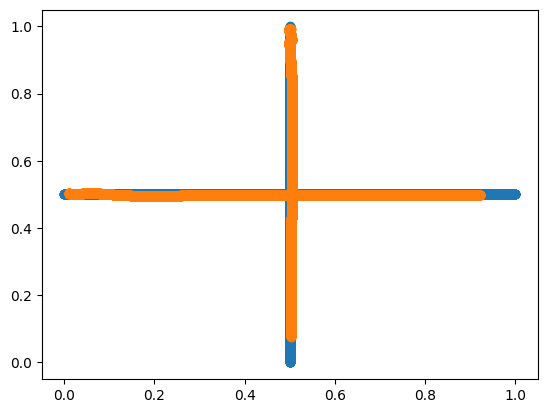

In [65]:
plt.scatter(xs[0].cpu()[:,0], xs[0].cpu()[:,1])
plt.scatter(recons[-1].cpu()[:,0], recons[-1].cpu()[:,1])

(0.0, 1.0)

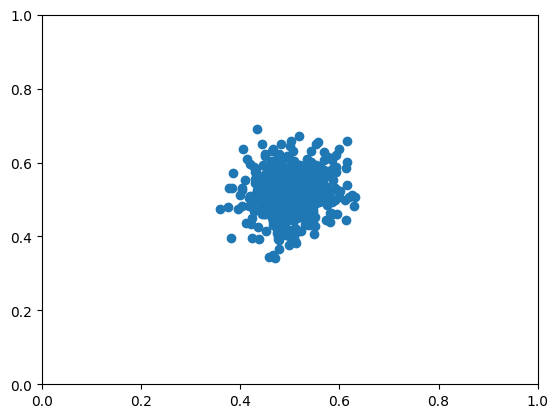

In [83]:
## generate new images by VAE
sample_zs = torch.randn(500, latent_dim).to('cuda:1')/100
model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs)
    generated_imgs = generated_imgs.cpu().numpy()
generated_imgs = np.array(generated_imgs)

plt.scatter(generated_imgs[:,0], generated_imgs[:,1])
plt.xlim(0.,1.)
plt.ylim(0.,1.)

In [69]:
mu.shape, log_var.shape

(torch.Size([20000, 2]), torch.Size([20000, 2]))

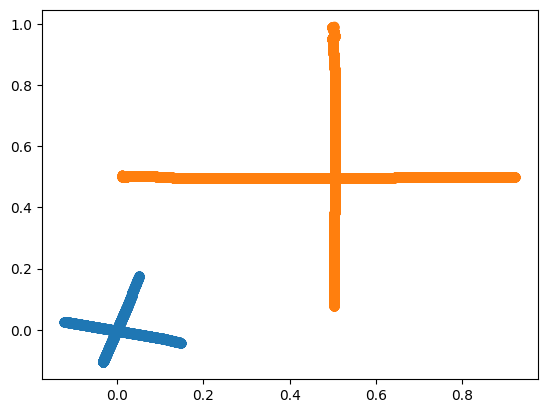

In [80]:
temp = model.decoder(mu).cpu().detach()
temp_mu = mu.cpu().detach()
plt.scatter(temp_mu[:,0], temp_mu[:,1])
plt.scatter(temp[:,0], temp[:,1])

Trying VAE with uniform box distributions instead

In [93]:
input_dim = 2
fc_dim = 15
latent_dim = 2 # same as the original dim

epochs = 4000

device = DEVICE
print(f'{device=}')

model = VAE(input_dim, fc_dim, latent_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

print('params', sum([p.numel() for p in model.parameters()]))

losslog = []
recons = []
xs = []
for epoch in tqdm(range(epochs)):
    for i, (images) in enumerate(train_loader):
        images = images.to(DEVICE)
        recon, mu, log_var = model(images, uniform=True)
        loss1, loss2, recon, x = model.compute_loss(images, recon, mu, log_var)
        with torch.no_grad() : recons.append(recon.detach()); xs.append(x.detach())
        loss = 0.1*loss1 + loss2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad() : losslog.append(loss.item())
    if epoch%300==0 : 
        tqdm.write(f'Epoch {epoch}, loss1 {loss1.item()}, loss2 {loss2.item()}')

device='cuda:1'
params 666


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch 0, loss1 0.09711397439241409, loss2 1.3962568044662476
Epoch 300, loss1 0.3249583840370178, loss2 1.3000144958496094
Epoch 600, loss1 0.525363564491272, loss2 1.2238572835922241
Epoch 900, loss1 0.5203023552894592, loss2 1.221612811088562
Epoch 1200, loss1 0.5222508907318115, loss2 1.2200188636779785
Epoch 1500, loss1 0.5260600447654724, loss2 1.2195247411727905
Epoch 1800, loss1 0.5229926705360413, loss2 1.2193421125411987
Epoch 2100, loss1 0.5209291577339172, loss2 1.2200859785079956
Epoch 2400, loss1 0.5195741057395935, loss2 1.2198622226715088
Epoch 2700, loss1 0.5193392038345337, loss2 1.2194993495941162
Epoch 3000, loss1 0.5210425853729248, loss2 1.2196544408798218
Epoch 3300, loss1 0.5205300450325012, loss2 1.2195396423339844
Epoch 3600, loss1 0.5204703211784363, loss2 1.2193849086761475
Epoch 3900, loss1 0.5203992128372192, loss2 1.2193843126296997


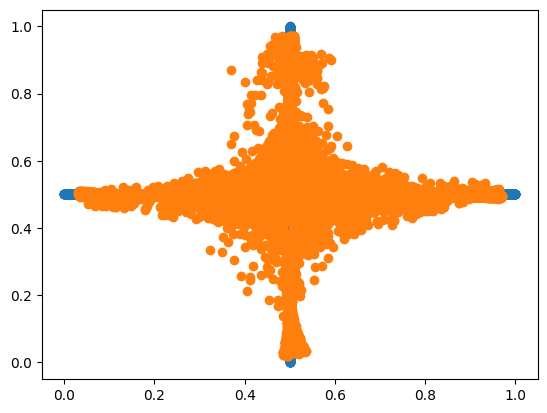

In [94]:
plt.scatter(xs[0].cpu()[:,0], xs[0].cpu()[:,1])
plt.scatter(recons[-1].cpu()[:,0], recons[-1].cpu()[:,1])

(0.0, 1.0)

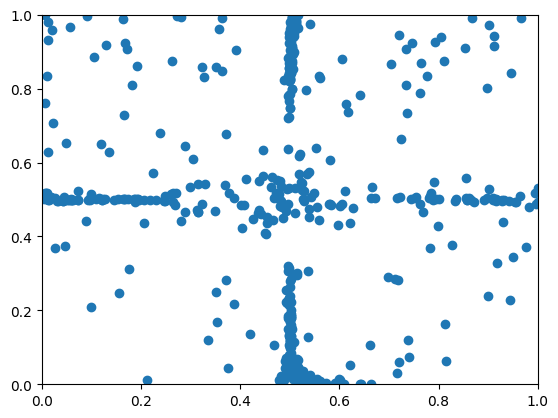

In [96]:
## generate new images by VAE
sample_zs = torch.randn(500, latent_dim).to('cuda:1')
model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs)
    generated_imgs = generated_imgs.cpu().numpy()
generated_imgs = np.array(generated_imgs)

plt.scatter(generated_imgs[:,0], generated_imgs[:,1])
plt.xlim(0.,1.)
plt.ylim(0.,1.)

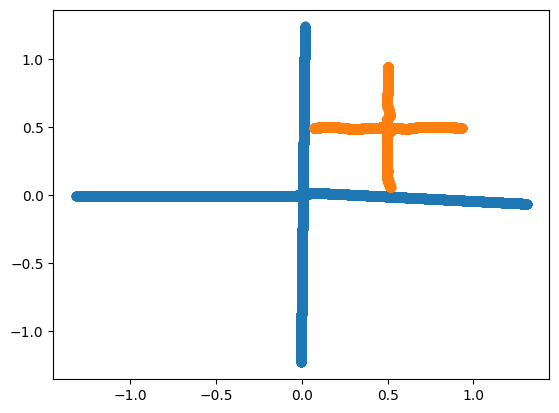

In [97]:
temp = model.decoder(mu).cpu().detach()
temp_mu = mu.cpu().detach()
plt.scatter(temp_mu[:,0], temp_mu[:,1])
plt.scatter(temp[:,0], temp[:,1])

Manually tweaking the distributions to be a partition of the entire space

In [131]:
class VAE(nn.Module):
    """VAE"""
    
    def __init__(self, input_dim, fc_dim, latent_dim):
        super().__init__()
        
        self.encoder = Encoder(input_dim, fc_dim, latent_dim).to(DEVICE)
        self.decoder = Decoder(latent_dim, fc_dim, input_dim).to(DEVICE)
        
    def sample_z(self, mu, log_var):
        """sample z by reparameterization trick"""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    def sample_z_uniform(self, centre, widths) :
        temp = torch.rand_like(centre) - 0.5 # centred at origin 
        return torch.exp(widths)*2*temp + centre
    
    def forward(self, x, point=False, uniform=False):
        mu, log_var = self.encoder(x)
        if point : z = mu 
        elif uniform : z = self.sample_z_uniform(mu, log_var)
        else : z = self.sample_z(mu, log_var).to(DEVICE)
        recon = self.decoder(z)
        return recon, mu, log_var
    
    def compute_loss(self, x, recon, mu, log_var):
        """compute loss of VAE"""
        
        # KL loss
        # kl_loss = (0.5*(log_var.exp() + mu ** 2 - 1 - log_var)).sum(1).mean()
        kl_loss = 0
        comp = torch.ones_like(mu)*1.5
        comp_mean = comp.clone()
        comp_mean[:,0][(x[:,0]<0.5) & (x[:,1]<0.52)] = -1.5 
        comp_mean[:,1][(x[:,1]>0.5) & (x[:,0]<0.52)] = -1.5 
        comp_mean[:,0][(x[:,1]<0.5) & (x[:,0]<0.52)] = -1.5 
        comp_mean[:,1][(x[:,1]<0.5) & (x[:,0]<0.52)] = -1.5 
        kl_loss = ((mu - comp_mean)**2 + (torch.exp(log_var) - comp)**2).sum(-1).mean()
        # for a,m,v in zip(x,mu,log_var) :
        #     if abs(a[1]-0.5)<0.02 and a[0]>0.5 : kl_loss += (m - torch.tensor([1.5,1.5], device=mu.device))**2 + (torch.exp(v) - torch.tensor([1.5,1.5], device=mu.device))**2
        #     if abs(a[1]-0.5)<0.02 and a[0]<0.5 : kl_loss += (m - torch.tensor([-1.5,1.5], device=mu.device))**2 + (torch.exp(v) - torch.tensor([1.5,1.5], device=mu.device))**2
        #     if abs(a[0]-0.5)<0.02 and a[1]>0.5 : kl_loss += (m - torch.tensor([1.5,-1.5], device=mu.device))**2 + (torch.exp(v) - torch.tensor([1.5,1.5], device=mu.device))**2
        #     if abs(a[0]-0.5)<0.02 and a[1]<0.5 : kl_loss += (m - torch.tensor([-1.5,-1.5], device=mu.device))**2 + (torch.exp(v) - torch.tensor([1.5,1.5], device=mu.device))**2
        
        # recon loss
        
        recon_loss = F.binary_cross_entropy(recon, x, reduction="none").sum([1]).mean()
        
        return kl_loss, recon_loss, recon, x

In [132]:
input_dim = 2
fc_dim = 15
latent_dim = 2 # same as the original dim

epochs = 4000

device = DEVICE
print(f'{device=}')

model = VAE(input_dim, fc_dim, latent_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

print('params', sum([p.numel() for p in model.parameters()]))

losslog = []
recons = []
xs = []
for epoch in tqdm(range(epochs)):
    for i, (images) in enumerate(train_loader):
        images = images.to(DEVICE)
        recon, mu, log_var = model(images, uniform=True)
        loss1, loss2, recon, x = model.compute_loss(images, recon, mu, log_var)
        with torch.no_grad() : recons.append(recon.detach()); xs.append(x.detach())
        loss = 0.1*loss1 + loss2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad() : losslog.append(loss.item())
    if epoch%300==0 : 
        tqdm.write(f'Epoch {epoch}, loss1 {loss1.item()}, loss2 {loss2.item()}')

device='cuda:1'
params 666


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch 0, loss1 5.021148204803467, loss2 1.393022060394287
Epoch 300, loss1 2.651719093322754, loss2 1.31936514377594
Epoch 600, loss1 1.5969345569610596, loss2 1.2749916315078735
Epoch 900, loss1 0.9339836835861206, loss2 1.2367035150527954
Epoch 1200, loss1 0.7322336435317993, loss2 1.236768364906311
Epoch 1500, loss1 0.6368395090103149, loss2 1.2368594408035278
Epoch 1800, loss1 0.5613316893577576, loss2 1.2382451295852661
Epoch 2100, loss1 0.49201712012290955, loss2 1.2392771244049072
Epoch 2400, loss1 0.4335784912109375, loss2 1.2409040927886963
Epoch 2700, loss1 0.38382741808891296, loss2 1.2426135540008545
Epoch 3000, loss1 0.34072333574295044, loss2 1.243265151977539
Epoch 3300, loss1 0.30182084441185, loss2 1.2442437410354614
Epoch 3600, loss1 0.2670620083808899, loss2 1.2445701360702515
Epoch 3900, loss1 0.23697343468666077, loss2 1.245598554611206


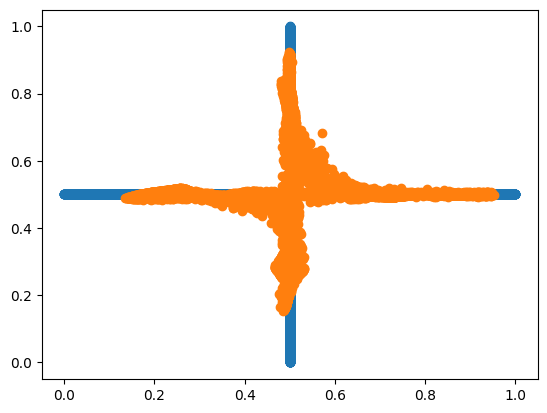

In [133]:
plt.scatter(xs[0].cpu()[:,0], xs[0].cpu()[:,1])
plt.scatter(recons[-1].cpu()[:,0], recons[-1].cpu()[:,1])

(0.0, 1.0)

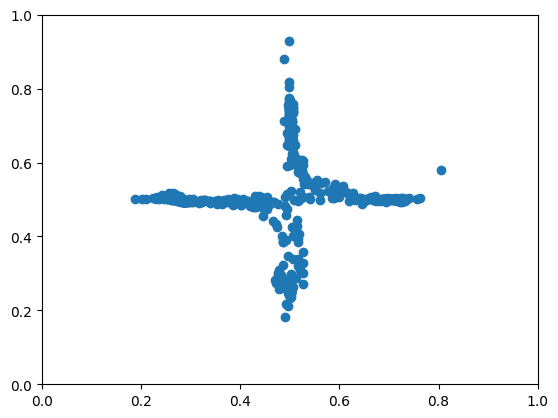

In [134]:
## generate new images by VAE
sample_zs = torch.randn(500, latent_dim).to('cuda:1')
model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs)
    generated_imgs = generated_imgs.cpu().numpy()
generated_imgs = np.array(generated_imgs)

plt.scatter(generated_imgs[:,0], generated_imgs[:,1])
plt.xlim(0.,1.)
plt.ylim(0.,1.)

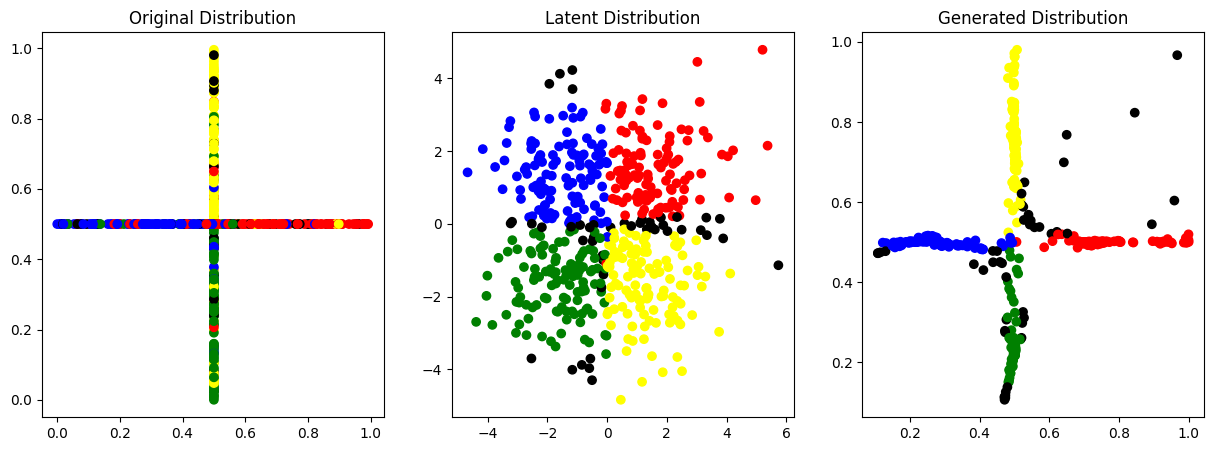

In [135]:
original = next(iter(train_loader))
mu, var = model.encoder(original.cuda(1))
latent = model.sample_z(mu, var)
generations = model.decoder(latent)

latent = latent.cpu().detach()
generations = generations.cpu().detach()

colors = [color(x,y) for (x,y) in generations[::40]]

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Original Distribution')
plt.scatter(x=[i[0] for i in original[::40]], y=[i[1] for i in original[::40]], c=colors)
plt.subplot(1,3,2)
plt.title('Latent Distribution')
plt.scatter(x=[i[0] for i in latent[::40]], y=[i[1] for i in latent[::40]], c=colors)
plt.subplot(1,3,3)
plt.title('Generated Distribution')
plt.scatter(x=[i[0] for i in generations[::40]], y=[i[1] for i in generations[::40]], c=colors)

Trying without the kl div loss, to see if it forms proper clusters

In [6]:
input_dim = 2
fc_dim = 15
latent_dim = 2 # same as the original dim

epochs = 4000

device = DEVICE
print(f'{device=}')

# transform=transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=0, std=4.)
# ])

dataset = cross_dataset(cross_data)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
# test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

model = VAE(input_dim, fc_dim, latent_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

print('params', sum([p.numel() for p in model.parameters()]))

device='cuda:1'
params 666


In [7]:
losslog = []
recons = []
xs = []
for epoch in tqdm(range(epochs)):
    for i, (images) in enumerate(train_loader):
        images = images.to(DEVICE)
        recon, mu, log_var = model(images)
        loss1, loss2, recon, x = model.compute_loss(images, recon, mu, log_var)
        with torch.no_grad() : recons.append(recon.detach()); xs.append(x.detach())
        loss = loss2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad() : losslog.append(loss.item())
    if epoch%300==0 : 
        tqdm.write(f'Epoch {epoch}, loss1 {loss1.item()}, loss2 {loss2.item()}')

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch 0, loss1 0.08972837030887604, loss2 1.3979030847549438
Epoch 300, loss1 7.150646686553955, loss2 1.1999788284301758
Epoch 600, loss1 11.438520431518555, loss2 1.195717215538025
Epoch 900, loss1 13.800115585327148, loss2 1.1948671340942383
Epoch 1200, loss1 15.521333694458008, loss2 1.1943726539611816
Epoch 1500, loss1 16.906768798828125, loss2 1.1940982341766357
Epoch 1800, loss1 18.129859924316406, loss2 1.1939595937728882
Epoch 2100, loss1 19.37079620361328, loss2 1.193892478942871
Epoch 2400, loss1 20.38990592956543, loss2 1.1938565969467163
Epoch 2700, loss1 21.22264289855957, loss2 1.1938353776931763
Epoch 3000, loss1 21.888784408569336, loss2 1.1938217878341675
Epoch 3300, loss1 22.435808181762695, loss2 1.1938116550445557
Epoch 3600, loss1 22.92885971069336, loss2 1.193831205368042
Epoch 3900, loss1 23.416595458984375, loss2 1.1937942504882812


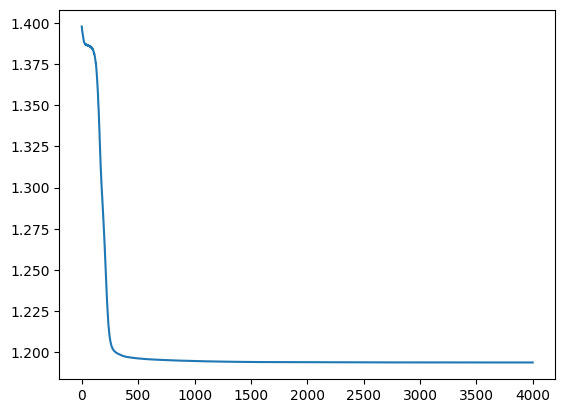

In [8]:
plt.plot(losslog)

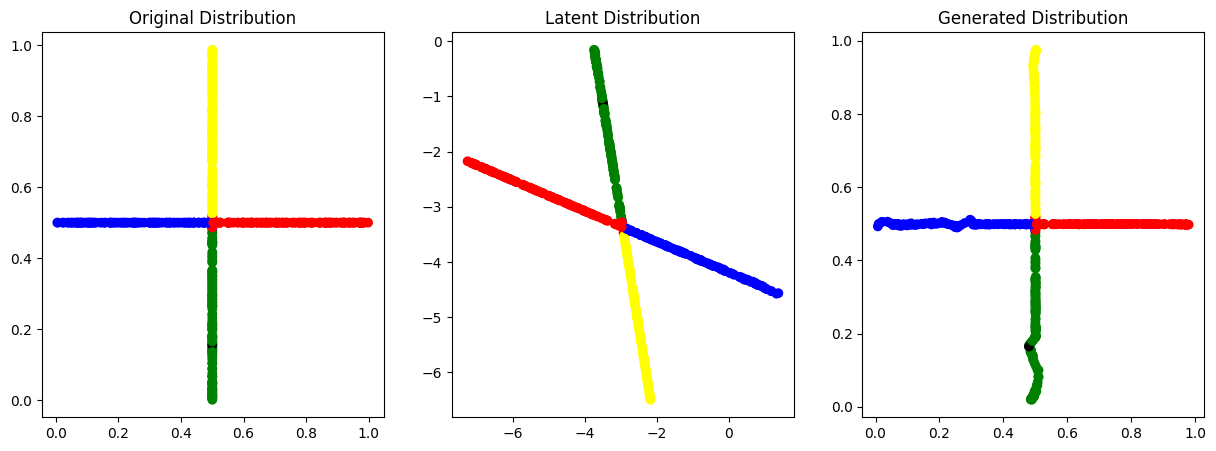

In [10]:
def color(x, y) : 
    if abs(y-0.5)<0.02 and x>0.5 : return 'red'
    if abs(y-0.5)<0.02 and x<0.5 : return 'blue'
    if abs(x-0.5)<0.02 and y>0.5 : return 'yellow'
    if abs(x-0.5)<0.02 and y<0.5 : return 'green'
    return 'black'

original = next(iter(train_loader))
mu, var = model.encoder(original.cuda(1))
latent = model.sample_z(mu, var)
generations = model.decoder(latent)

latent = latent.cpu().detach()
generations = generations.cpu().detach()

colors = [color(x,y) for (x,y) in generations[::40]]

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Original Distribution')
plt.scatter(x=[i[0] for i in original[::40]], y=[i[1] for i in original[::40]], c=colors)
plt.subplot(1,3,2)
plt.title('Latent Distribution')
plt.scatter(x=[i[0] for i in latent[::40]], y=[i[1] for i in latent[::40]], c=colors)
plt.subplot(1,3,3)
plt.title('Generated Distribution')
plt.scatter(x=[i[0] for i in generations[::40]], y=[i[1] for i in generations[::40]], c=colors)

In [15]:
mu.shape

torch.Size([20000, 2])

In [37]:
sigma = torch.cov(mu.cpu().detach().transpose(0, 1))
sup_mean = torch.mean(mu.cpu().detach(), dim=0)
sup_mean.shape, sigma.shape

(torch.Size([2]), torch.Size([2, 2]))

In [38]:
# sampling from the sup_mean, sigma distribution
eps = torch.randn((500,2))
sampled = sup_mean + eps@sigma
sampled.shape

torch.Size([500, 2])

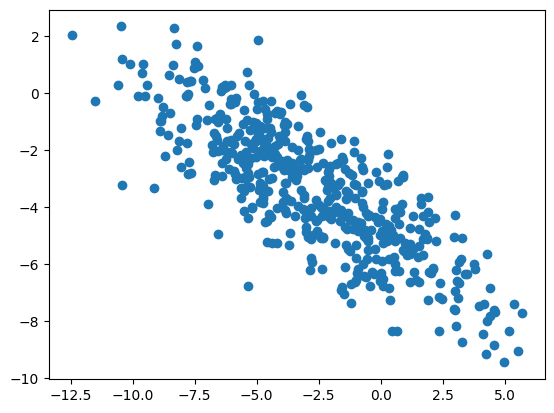

In [39]:
plt.scatter(*sampled.transpose(0,1))

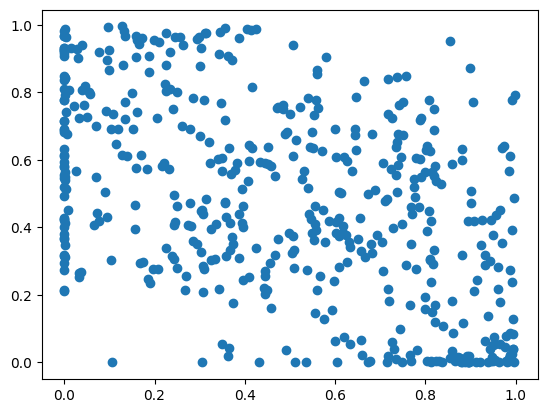

In [43]:
generations2 = model.decoder(sampled.cuda(1)).cpu().detach()
plt.scatter(*generations2.transpose(0,1))

## Trying this with a cross dataset on 5d

In [4]:
class cross_dataset(torch.utils.data.Dataset) :
    def __init__(self, arr, transforms=None, subset=0) :
        self.arr = arr
        self.transforms = transforms
        if subset>0 : self.arr = self.arr[:subset]
    def __len__(self) :
        return len(self.arr)
    def __getitem__(self, idx) :
        Data = self.arr[idx]
        if self.transforms :
            Data = self.transforms(Data)
        return torch.tensor(Data)


In [5]:
num_points = 10000
ndim = 5

cross_data = torch.zeros((num_points, ndim))
axes = torch.randint(0, 5, (num_points,))
norm = torch.rand(num_points)
cross_data[torch.arange(num_points), axes] = norm

# plt.scatter([i[0] for i in cross_data], [i[1] for i in cross_data])

In [6]:
input_dim = 5
fc_dim = 15
latent_dim = 2 # same as the original dim

epochs = 4000

device = DEVICE
print(f'{device=}')

# transform=transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=0, std=4.)
# ])

dataset = cross_dataset(cross_data)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
# test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

model = VAE(input_dim, fc_dim, latent_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

print('params', sum([p.numel() for p in model.parameters()]))

device='cpu'
params 759


In [7]:
losslog = []
for epoch in tqdm(range(epochs)):
    for i, (images) in enumerate(train_loader):
        images = images.to(DEVICE)
        recon, mu, log_var = model(images)
        loss1, loss2, recon, x = model.compute_loss(images, recon, mu, log_var)
        loss = loss2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad() : losslog.append(loss.item())
    if epoch%300==0 : 
        tqdm.write(f'Epoch {epoch}, loss1 {loss1.item()}, loss2 {loss2.item()}')

  0%|          | 0/4000 [00:00<?, ?it/s]

/tmp/ipykernel_83745/3719772061.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(Data)


Epoch 0, loss1 0.05178220942616463, loss2 3.463212013244629
Epoch 300, loss1 3.467620372772217, loss2 1.4785751104354858
Epoch 600, loss1 26.25878143310547, loss2 0.569831371307373
Epoch 900, loss1 39.63908767700195, loss2 0.5214789509773254
Epoch 1200, loss1 46.70356369018555, loss2 0.5125625729560852
Epoch 1500, loss1 52.4197998046875, loss2 0.5094797611236572
Epoch 1800, loss1 57.888511657714844, loss2 0.508074164390564
Epoch 2100, loss1 62.76155471801758, loss2 0.5071999430656433
Epoch 2400, loss1 66.9561538696289, loss2 0.5066224932670593
Epoch 2700, loss1 70.43892669677734, loss2 0.5062786340713501
Epoch 3000, loss1 73.4698715209961, loss2 0.5060383677482605
Epoch 3300, loss1 76.11891174316406, loss2 0.5058212280273438
Epoch 3600, loss1 78.5146484375, loss2 0.5057123303413391
Epoch 3900, loss1 80.46597290039062, loss2 0.5055416822433472


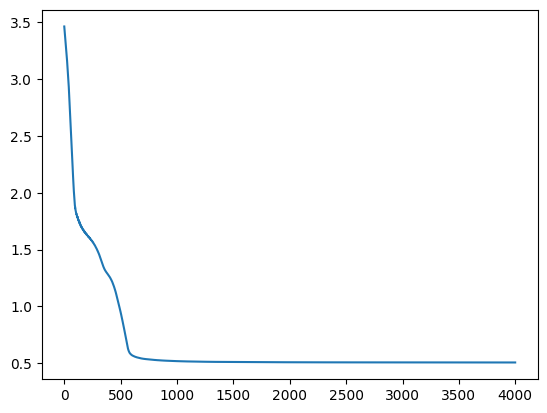

In [8]:
plt.plot(losslog)

/tmp/ipykernel_83745/3719772061.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(Data)


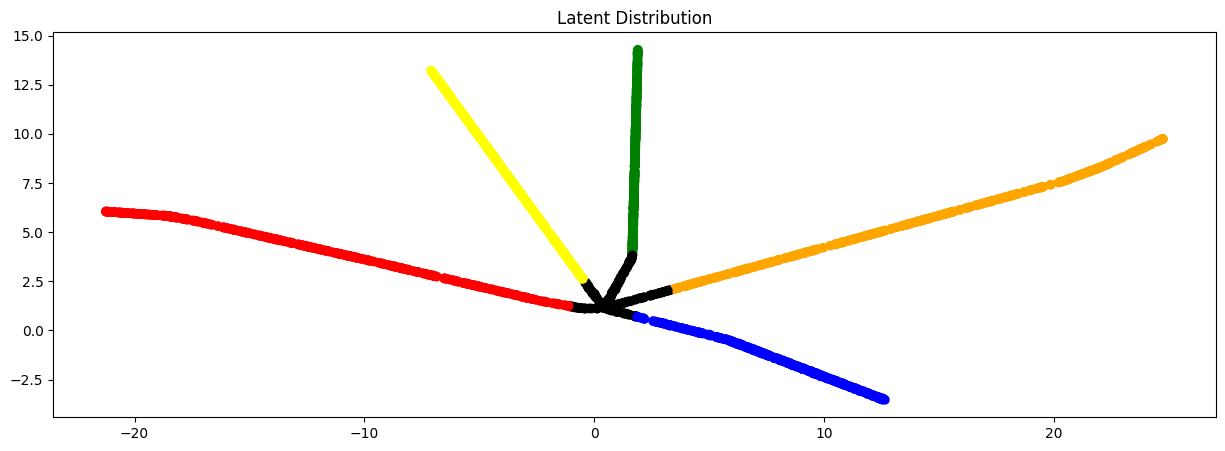

In [69]:
def color(x) : 
    a = x.argmax()
    c = ['green','blue','yellow','red','orange']
    vals = torch.sqrt(x.norm()**2 - x[a]**2)
    if vals<=0.001 : return c[a]
    return 'black'

original = next(iter(train_loader))
mu, var = model.encoder(original)
latent = model.sample_z(mu, var)
generations = model.decoder(latent)

latent = latent.cpu().detach()
generations = generations.cpu().detach()

step = 5
colors = [color(x) for x in generations[::step]]

plt.figure(figsize=(15,5))
# plt.subplot(1,3,1)
# plt.title('Original Distribution')
# plt.scatter(x=[i[0] for i in original[::40]], y=[i[1] for i in original[::40]], c=colors)
# plt.subplot(1,3,2)
plt.title('Latent Distribution')
plt.scatter(x=[i[0] for i in latent[::step]], y=[i[1] for i in latent[::step]], c=colors)
# plt.subplot(1,3,3)
# plt.title('Generated Distribution')
# plt.scatter(x=[i[0] for i in generations[::40]], y=[i[1] for i in generations[::40]], c=colors)

In [70]:
sigma = torch.cov(mu.cpu().detach().transpose(0, 1))
sup_mean = torch.mean(mu.cpu().detach(), dim=0)
sup_mean.shape, sigma.shape

(torch.Size([2]), torch.Size([2, 2]))

In [71]:
# sampling from the sup_mean, sigma distribution
eps = torch.randn((500,2))
sampled = sup_mean + eps@sigma
sampled.shape

torch.Size([500, 2])

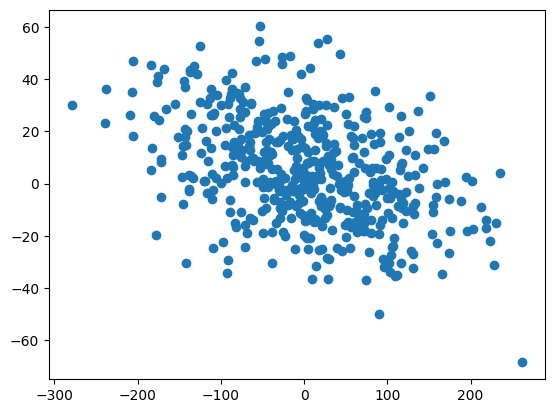

In [72]:
plt.scatter(*sampled.transpose(0,1))

In [78]:
generations2 = model.decoder(sampled).cpu().detach()
indices = generations2.argmax(-1)
val = generations2[torch.arange(500), indices]
diffs = torch.sqrt(generations2.norm(dim=-1)**2 - val**2)
cs = [color(x) for x in generations2]

diffs.abs().max()

tensor(0.9973)

In [83]:
num_correct = sum(np.array(cs)!='black')
num_correct

480

In [84]:
diffs[np.array(cs)!='black'].abs().max()

tensor(0.0006)

In [88]:
generations2_eps = model.decoder(eps).cpu().detach()
indices_eps = generations2_eps.argmax(-1)
val_eps = generations2_eps[torch.arange(500), indices_eps]
diffs_eps = torch.sqrt(generations2_eps.norm(dim=-1)**2 - val_eps**2)
cs_eps = [color(x) for x in generations2_eps]

diffs_eps.abs().max()

tensor(0.3590)

In [89]:
num_correct_eps = sum(np.array(cs_eps)!='black')
num_correct_eps

34

In [90]:
diffs_eps[np.array(cs_eps)!='black'].abs().max()

tensor(0.0010)

In [92]:
sup_mean, sigma

(tensor([1.4012, 4.6507]),
 tensor([[97.2557, -7.6300],
         [-7.6300, 18.2914]]))

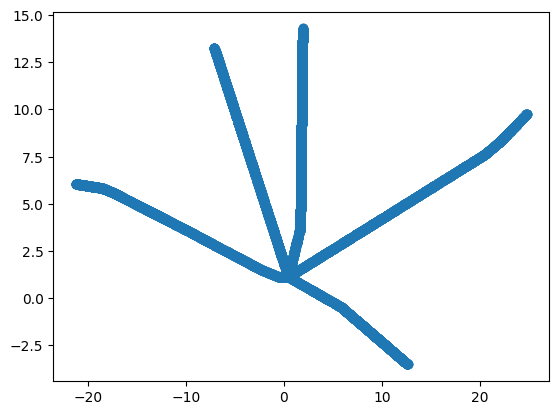

In [95]:
plt.scatter(*mu.cpu().detach().transpose(0,1))

In [96]:
# running with the KL divergence term as well

input_dim = 5
fc_dim = 15
latent_dim = 2 # same as the original dim

epochs = 4000

device = DEVICE
print(f'{device=}')

# transform=transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=0, std=4.)
# ])

dataset = cross_dataset(cross_data)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
# test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

model = VAE(input_dim, fc_dim, latent_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

print('params', sum([p.numel() for p in model.parameters()]))

losslog = []
for epoch in tqdm(range(epochs)):
    for i, (images) in enumerate(train_loader):
        images = images.to(DEVICE)
        recon, mu, log_var = model(images)
        loss1, loss2, recon, x = model.compute_loss(images, recon, mu, log_var)
        loss = 0.1*loss1 + loss2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad() : losslog.append(loss.item())
    if epoch%300==0 : 
        tqdm.write(f'Epoch {epoch}, loss1 {loss1.item()}, loss2 {loss2.item()}')

device='cpu'
params 759


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch 0, loss1 0.05942686274647713, loss2 3.610560655593872


/tmp/ipykernel_83745/3719772061.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(Data)


Epoch 300, loss1 0.05129185691475868, loss2 1.6307803392410278
Epoch 600, loss1 1.407060980796814, loss2 1.1650567054748535
Epoch 900, loss1 2.4219491481781006, loss2 0.6257610321044922
Epoch 1200, loss1 2.4265973567962646, loss2 0.601553201675415
Epoch 1500, loss1 2.4397709369659424, loss2 0.5914640426635742
Epoch 1800, loss1 2.4407355785369873, loss2 0.5876485705375671
Epoch 2100, loss1 2.4523050785064697, loss2 0.5836820602416992
Epoch 2400, loss1 2.4588403701782227, loss2 0.5803595781326294
Epoch 2700, loss1 2.4543511867523193, loss2 0.5779238939285278
Epoch 3000, loss1 2.485185146331787, loss2 0.5767620205879211
Epoch 3300, loss1 2.4724838733673096, loss2 0.57282954454422
Epoch 3600, loss1 2.4719600677490234, loss2 0.5748277306556702
Epoch 3900, loss1 2.47381329536438, loss2 0.5747951865196228


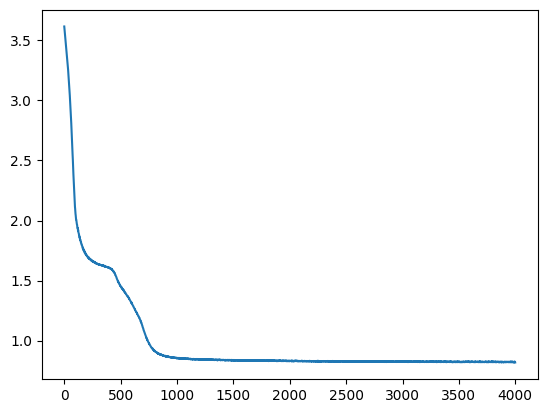

In [97]:
plt.plot(losslog)

/tmp/ipykernel_83745/3719772061.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(Data)


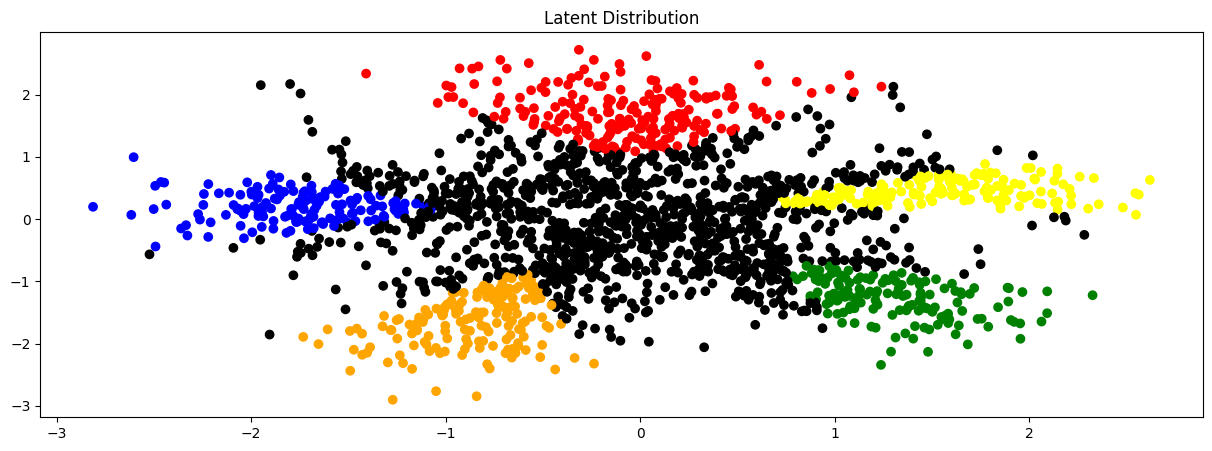

In [98]:
def color(x) : 
    a = x.argmax()
    c = ['green','blue','yellow','red','orange']
    vals = torch.sqrt(x.norm()**2 - x[a]**2)
    if vals<=0.001 : return c[a]
    return 'black'

original = next(iter(train_loader))
mu, var = model.encoder(original)
latent = model.sample_z(mu, var)
generations = model.decoder(latent)

latent = latent.cpu().detach()
generations = generations.cpu().detach()

step = 5
colors = [color(x) for x in generations[::step]]

plt.figure(figsize=(15,5))
# plt.subplot(1,3,1)
# plt.title('Original Distribution')
# plt.scatter(x=[i[0] for i in original[::40]], y=[i[1] for i in original[::40]], c=colors)
# plt.subplot(1,3,2)
plt.title('Latent Distribution')
plt.scatter(x=[i[0] for i in latent[::step]], y=[i[1] for i in latent[::step]], c=colors)
# plt.subplot(1,3,3)
# plt.title('Generated Distribution')
# plt.scatter(x=[i[0] for i in generations[::40]], y=[i[1] for i in generations[::40]], c=colors)

In [100]:
sigma = torch.cov(mu.cpu().detach().transpose(0, 1))
sup_mean = torch.mean(mu.cpu().detach(), dim=0)

# sampling from the sup_mean, sigma distribution
eps = torch.randn((500,2))
sampled = sup_mean + eps@sigma
sampled.shape

torch.Size([500, 2])

In [101]:
sup_mean, sigma

(tensor([0.0051, 0.0002]),
 tensor([[ 0.8956, -0.0052],
         [-0.0052,  0.9448]]))

In [104]:
generations2 = model.decoder(sampled).cpu().detach()
indices = generations2.argmax(-1)
val = generations2[torch.arange(500), indices]
diffs = torch.sqrt(generations2.norm(dim=-1)**2 - val**2)
cs = [color(x) for x in generations2]

diffs.abs().max(), 'num_correct_eps', sum(np.array(cs)!='black')

(tensor(0.2717), 'num_correct_eps', 90)

In [105]:
generations2_eps = model.decoder(eps).cpu().detach()
indices_eps = generations2_eps.argmax(-1)
val_eps = generations2_eps[torch.arange(500), indices_eps]
diffs_eps = torch.sqrt(generations2_eps.norm(dim=-1)**2 - val_eps**2)
cs_eps = [color(x) for x in generations2_eps]

diffs_eps.abs().max(), 'num_correct_eps', sum(np.array(cs_eps)!='black')

(tensor(0.3640), 'num_correct_eps', 105)

/tmp/ipykernel_83745/3719772061.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(Data)


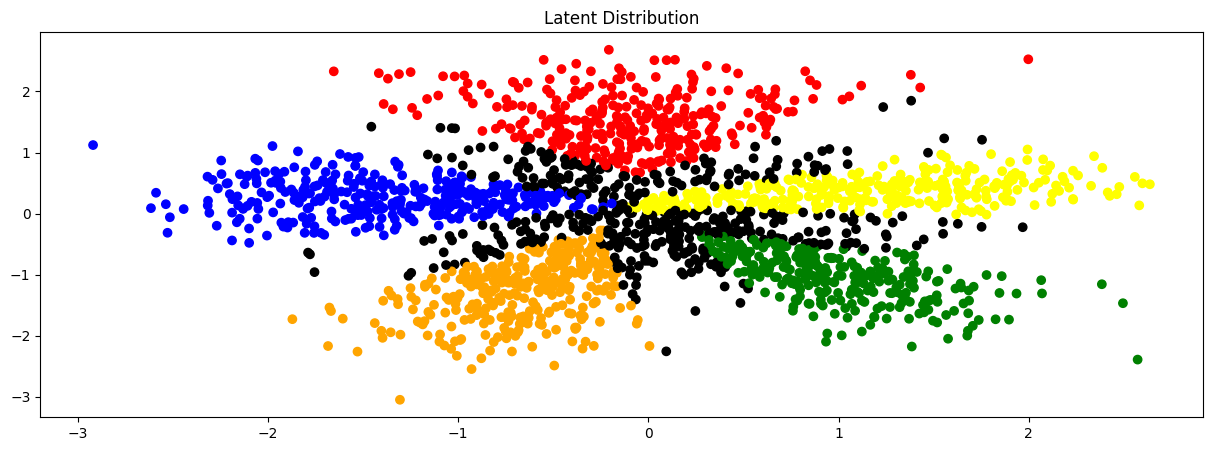

In [106]:
# with a different threshold

def color(x) : 
    a = x.argmax()
    c = ['green','blue','yellow','red','orange']
    vals = torch.sqrt(x.norm()**2 - x[a]**2)
    if vals<=0.01 : return c[a]
    return 'black'

original = next(iter(train_loader))
mu, var = model.encoder(original)
latent = model.sample_z(mu, var)
generations = model.decoder(latent)

latent = latent.cpu().detach()
generations = generations.cpu().detach()

step = 5
colors = [color(x) for x in generations[::step]]

plt.figure(figsize=(15,5))
# plt.subplot(1,3,1)
# plt.title('Original Distribution')
# plt.scatter(x=[i[0] for i in original[::40]], y=[i[1] for i in original[::40]], c=colors)
# plt.subplot(1,3,2)
plt.title('Latent Distribution')
plt.scatter(x=[i[0] for i in latent[::step]], y=[i[1] for i in latent[::step]], c=colors)
# plt.subplot(1,3,3)
# plt.title('Generated Distribution')
# plt.scatter(x=[i[0] for i in generations[::40]], y=[i[1] for i in generations[::40]], c=colors)

In [107]:
generations2 = model.decoder(sampled).cpu().detach()
indices = generations2.argmax(-1)
val = generations2[torch.arange(500), indices]
diffs = torch.sqrt(generations2.norm(dim=-1)**2 - val**2)
cs = [color(x) for x in generations2]

print('mu-sigma', diffs.abs().max(), 'num_correct_eps', sum(np.array(cs)!='black'))

generations2_eps = model.decoder(eps).cpu().detach()
indices_eps = generations2_eps.argmax(-1)
val_eps = generations2_eps[torch.arange(500), indices_eps]
diffs_eps = torch.sqrt(generations2_eps.norm(dim=-1)**2 - val_eps**2)
cs_eps = [color(x) for x in generations2_eps]

print('0-I', diffs_eps.abs().max(), 'num_correct_eps', sum(np.array(cs_eps)!='black'))

mu-sigma tensor(0.2717) num_correct_eps 271
0-I tensor(0.3640) num_correct_eps 277


## Trying with the langevin MC sampling

In [6]:
input_dim = 2
fc_dim = 15
latent_dim = 2 # same as the original dim

epochs = 4000

device = DEVICE
print(f'{device=}')

# transform=transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=0, std=4.)
# ])

dataset = cross_dataset(cross_data)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
# test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

model = VAE(input_dim, fc_dim, latent_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

print('params', sum([p.numel() for p in model.parameters()]))
print('dataset', len(dataset))

device='cuda:1'
params 666
dataset 20000


In [8]:
losslog = []
recons = []
xs = []
for epoch in tqdm(range(epochs)):
    for i, (images) in enumerate(train_loader):
        images = images.to(DEVICE)
        recon, mu, log_var = model(images)
        loss1, loss2, recon, x = model.compute_loss(images, recon, mu, log_var)
        with torch.no_grad() : recons.append(recon.detach()); xs.append(x.detach())
        loss = 0.1*loss1 + loss2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad() : losslog.append(loss.item())
    if epoch%300==0 : 
        tqdm.write(f'Epoch {epoch}, loss1 {loss1.item()}, loss2 {loss2.item()}')

# optimizer.param_groups[0]['lr'] /= 10
# for epoch in tqdm(range(1200)):
#     for i, (images) in enumerate(train_loader):
#         images = images.to(DEVICE)
#         recon, mu, log_var = model(images)
#         loss = model.compute_loss(images, recon, mu, log_var)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         with torch.no_grad() : losslog.append(loss.item())
#     if epoch%1==0 : 
#         tqdm.write(f'Epoch {epoch}, loss {loss.item()}')

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch 0, loss1 0.04010867327451706, loss2 1.390483021736145
Epoch 300, loss1 0.05571156367659569, loss2 1.3783679008483887
Epoch 600, loss1 0.6193410754203796, loss2 1.3030152320861816
Epoch 900, loss1 0.8079844117164612, loss2 1.2784838676452637
Epoch 1200, loss1 0.8064550161361694, loss2 1.277959942817688
Epoch 1500, loss1 0.8137136697769165, loss2 1.2775218486785889
Epoch 1800, loss1 0.8075618743896484, loss2 1.2784640789031982
Epoch 2100, loss1 0.8144800662994385, loss2 1.277933955192566
Epoch 2400, loss1 0.8062388896942139, loss2 1.2784457206726074
Epoch 2700, loss1 0.8103589415550232, loss2 1.2771092653274536
Epoch 3000, loss1 0.8096868991851807, loss2 1.2782032489776611
Epoch 3300, loss1 0.8081066012382507, loss2 1.2786474227905273
Epoch 3600, loss1 0.8053909540176392, loss2 1.2778189182281494
Epoch 3900, loss1 0.8133629560470581, loss2 1.276493787765503


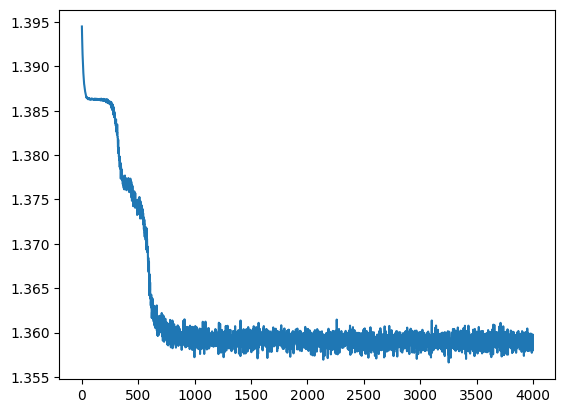

In [9]:
plt.plot(losslog)

(0.0, 1.0)

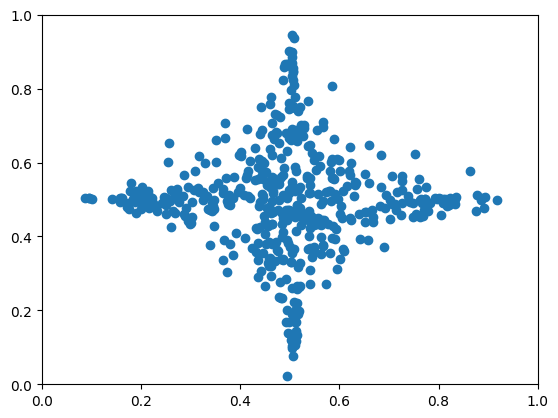

In [10]:
## generate new images by VAE
sample_zs = torch.randn(500, latent_dim).to('cuda:1')
model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs)
    generated_imgs = generated_imgs.cpu().numpy()
generated_imgs = np.array(generated_imgs)
plt.scatter(generated_imgs[:,0], generated_imgs[:,1])
plt.xlim(0.,1.)
plt.ylim(0.,1.)

In [21]:
gauss_std = 1/3
# pivot_indices = np.array([1,3,5,12,9,0,62,52,17,22])
# pivot_indices = np.arange(100)
model = torch.load('models/cross_gradExp.pt')
pivot_images = dataset[:] # [::20000//200] # [(dataset[:]-0.5).norm(dim=-1) >= 0.1,:] # [ ::20000//200]
with torch.no_grad() : encodings = model.encoder(pivot_images.to(next(model.parameters()).device))[0].cpu()
pivot_images, encodings = pivot_images.squeeze(), encodings.squeeze()
pivot_images.shape, encodings.shape

(torch.Size([20000, 2]), torch.Size([20000, 2]))

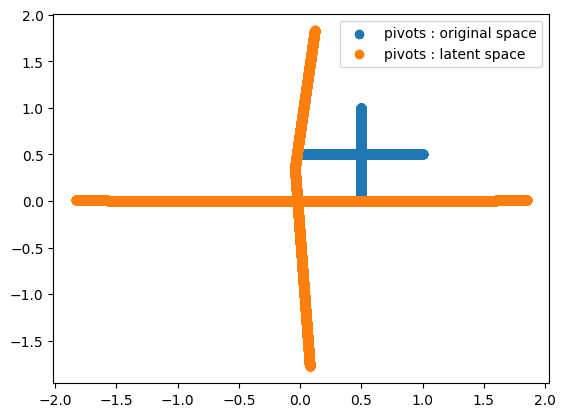

In [22]:
# visualizing the pivots
plt.scatter(pivot_images[:,0], pivot_images[:,1], label='pivots : original space')
plt.scatter(encodings[:,0], encodings[:,1], label='pivots : latent space')
plt.legend();

In [67]:
# potential function : sum of gaussians
def potential(z, encodings, sigma=gauss_std, pot=True) :
    z = z.view(-1, 1, encodings.shape[-1])
    ans = 0
    ans = torch.exp(-torch.norm(z-encodings, dim=-1)**2 / (2*sigma*sigma)).sum(-1)
    if pot : return -torch.log(ans)
    return ans
def potential_max(z, encodings, sigma=gauss_std, pot=True) :
    z = z.view(-1, 1, encodings.shape[-1])
    ans = 0
    ans = torch.exp(-torch.norm(z-encodings, dim=-1)**2 / (2*sigma*sigma)).max(-1).values
    if pot : return -torch.log(ans)
    return ans

In [66]:
torch.tensor([1,2,3,4]).max(-1).values

tensor(4)

In [68]:
def log_Q(potential, encodings, z_prime, z, step, pot=True):
    z.requires_grad_()
    grad = torch.autograd.grad(potential(z, encodings, pot=pot).mean(), z)[0]
    return -(torch.norm(z_prime - z + step * grad - 2*(1-int(pot))*step*grad, p=2, dim=1) ** 2) / (4 * step)

def metropolis_adjusted_langevin_algorithm(potential, encodings, n_samples=100000, step=0.001, k=50, pot=True):
    burn_in = 10000
    weight = 10.
    Z0 = torch.tensor([2., 0.]).view(1,-1) # torch.randn(1, encodings.shape[-1])
    Zi = Z0
    samples = []
    grads = []
    acc = []
    pbar = tqdm(range(k*n_samples + burn_in))
    for i in pbar:
        Zi.requires_grad_()
        u = potential(Zi, encodings, pot=pot).mean()
        grad = torch.autograd.grad(u, Zi)[0]; grads.append(grad)
        prop_Zi = Zi.detach() - step * weight *grad + np.sqrt(2 * step) * torch.randn(1, encodings.shape[-1])
        if not pot : prop_Zi += 2 * step * weight *grad
        if pot :
            log_ratio = -potential(prop_Zi, encodings).mean() + potential(Zi, encodings).mean() +\
                    log_Q(potential, encodings, Zi, prop_Zi, step, pot=pot) - log_Q(potential, encodings, prop_Zi, Zi, step, pot=pot)
        else :
            log_ratio = potential(prop_Zi, encodings).mean().exp() - potential(Zi, encodings).mean().exp() +\
                    log_Q(potential, encodings, Zi, prop_Zi, step, pot=pot) - log_Q(potential, encodings, prop_Zi, Zi, step, pot=pot)
        if torch.rand(1) < torch.exp(log_ratio):
            Zi = prop_Zi; acc.append(1)
        else : acc.append(0)
        samples.append(Zi.detach().numpy())
    return np.concatenate(samples, 0)[burn_in::k], grads, acc, np.concatenate(samples, 0)[:burn_in]

In [69]:
# showing images generated from the sampled distribution
## generate new images by VAE
# encodings = torch.tensor([[1.,0.], [-1.,0.]])

# latents = []
# for i in range(20) : latent, grads, acc, burns = metropolis_adjusted_langevin_algorithm(potential, encodings, n_samples=1); latents.append(latent)
latents, grads, acc, burns = metropolis_adjusted_langevin_algorithm(potential_max, encodings, n_samples=500, k=200, pot=True)
# with torch.no_grad() : images = model.decoder(torch.tensor(latents).to(next(model.decoder.parameters()).device)).cpu()
 
# generated_imgs = np.array(images)
# plt.scatter(generated_imgs[:,0], generated_imgs[:,1])
# plt.xlim(0.,1.)
# plt.ylim(0.,1.)

  0%|          | 0/110000 [00:00<?, ?it/s]

/home/ashameem/miniconda3/envs/ddpms/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/ashameem/miniconda3/envs/ddpms/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


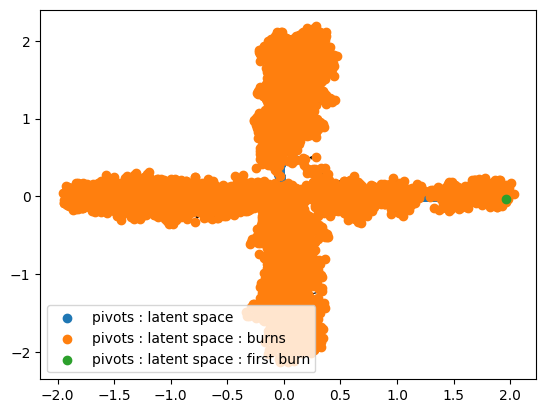

In [70]:
n_samples = len(burns)-1
y_pos = burns[:n_samples+1, 1]
x_pos = burns[:n_samples+1,0]
x_dir = x_pos[1:] - x_pos[:-1]
y_dir = y_pos[1:] - y_pos[:-1]
plt.quiver(x_pos[:-1], y_pos[:-1], 5*x_dir, 5*y_dir, angles='xy', units='xy', scale_units='xy', scale=5)
plt.scatter(encodings[:,0], encodings[:,1], label='pivots : latent space')
plt.scatter(burns[1:n_samples,0], burns[1:n_samples,1], label='pivots : latent space : burns')
plt.scatter(burns[:1,0], burns[:1,1], label='pivots : latent space : first burn')
plt.legend();

In [50]:
sum(acc) / len(acc)

0.0013428571428571428

In [27]:
sum(acc) / len(acc), sum(acc), len(acc)

(0.9998571428571429, 34995, 35000)

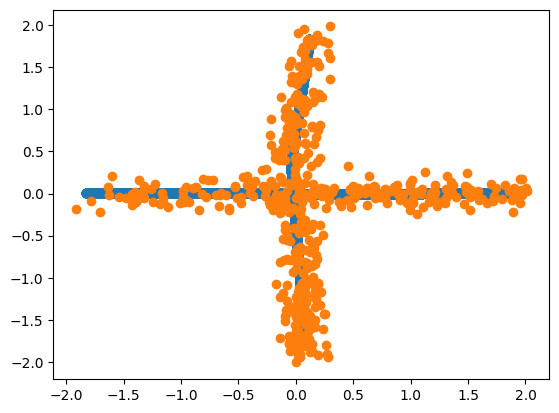

In [71]:
plt.scatter(encodings[:,0], encodings[:,1], label='pivots : latent space')
plt.scatter(latents[:,0], latents[:,1], label='generated vectors in latent space')
# plt.scatter(np.array(latents)[:,0,0], np.array(latents)[:,0,1], label='generated vectors in latent space')
# plt.scatter(burns[-200:,0], burns[-200:,1], label='pivots : latent space : burns')
# plt.legend();
# plt.xlim(-3., 3.)
# plt.ylim(-3., 3.)

In [72]:
limit = 3.
# encodings = torch.tensor([[1.5, 0.], [-1.5,0.]])
x = torch.linspace(-limit, limit, 50)
y = torch.linspace(-limit, limit, 50)
z = torch.tensor([(a,b) for a in x for b in y])
z.requires_grad_()
u = potential_max(z, encodings, pot=False, sigma=1/3).sum()
grad = torch.autograd.grad(u, z)[0].detach()

In [73]:
z.shape, u.shape, grad.shape

(torch.Size([2500, 2]), torch.Size([]), torch.Size([2500, 2]))

(-3.0, 3.0)

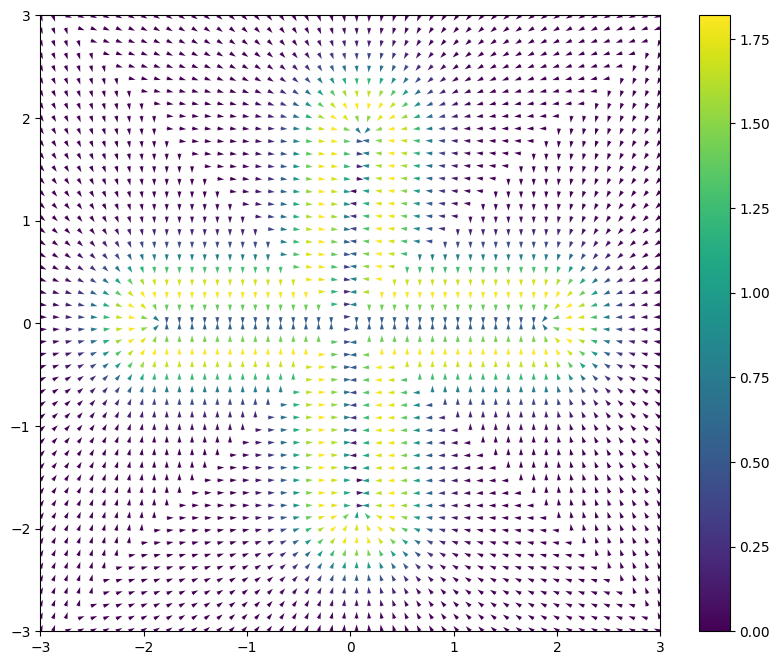

In [76]:
scale = 3
y_pos = z[:,1].detach()
x_pos = z[:,0].detach()
x_dir = grad[:,0]
y_dir = grad[:,1]
norms = (x_dir**2 + y_dir**2)**0.5
plt.figure(figsize=(10,8))
plt.quiver(x_pos, y_pos, scale*x_dir/norms, scale*y_dir/norms ,norms, scale_units='xy')
plt.colorbar()
plt.xlim(-3., 3.)
plt.ylim(-3., 3.)

In [77]:
torch.save(model, 'models/cross_gradExp.pt')

In [81]:
latents.shape, next(model.decoder.parameters()).device

((500, 2), device(type='cuda', index=1))

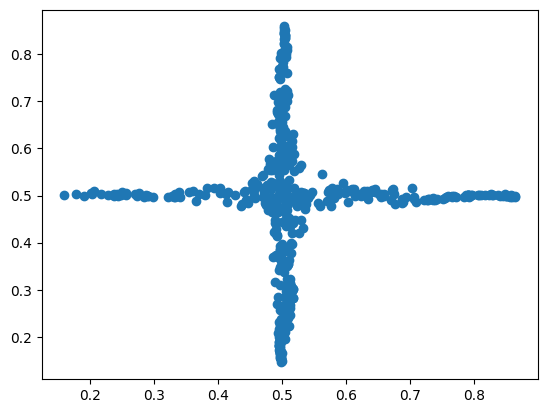

In [85]:
## Trying to generate using the latents sampled through langevin

with torch.no_grad() : generations = model.decoder(torch.tensor(latents).to(next(model.decoder.parameters()).device)).cpu()

plt.scatter(generations[:,0], generations[:,1])

In [83]:
generations.shape

torch.Size([500, 2])

### The same, on the concentric circles dataset

In [226]:
theta1 = 2*torch.pi*torch.randn((10000,))
theta2 = 2*torch.pi*torch.randn((10000,))
R1, R2 = 3/16, 8/16.
X1 =  R1 * torch.cos(theta1) + 0.5
X2 =  R2 * torch.cos(theta2) + 0.5
Y1 =  R1 * torch.sin(theta1) + 0.5
Y2 =  R2 * torch.sin(theta2) + 0.5
data1 = [(x,y) for x,y in zip(X1,Y1)]
data2 = [(x,y) for x,y in zip(X2,Y2)]
data = data1 + data2

class circle_dataset(torch.utils.data.Dataset) :
    def __init__(self, arr, transforms=None, subset=0) :
        self.arr = arr
        self.transforms = transforms
        if subset>0 : self.arr = self.arr[:subset]
    def __len__(self) :
        return len(self.arr)
    def __getitem__(self, idx) :
        Data = self.arr[idx]
        if self.transforms :
            Data = self.transforms(Data)
        return torch.tensor(Data).unsqueeze(0)



input_dim = 2
fc_dim = 15
latent_dim = 2 # same as the original dim
epochs = 4000
device = DEVICE
print(f'{device=}')
dataset = circle_dataset(data)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)

model = VAE(input_dim, fc_dim, latent_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

print('params', sum([p.numel() for p in model.parameters()]))
print('dataset', len(dataset))

device='cuda:1'
params 666
dataset 20000


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch 0, loss1 0.03652684763073921, loss2 0.6964135766029358
Epoch 300, loss1 0.46755439043045044, loss2 0.6046730279922485
Epoch 600, loss1 0.6551045775413513, loss2 0.5760790705680847
Epoch 900, loss1 0.6587327122688293, loss2 0.5750731825828552
Epoch 1200, loss1 0.6620335578918457, loss2 0.5749813914299011
Epoch 1500, loss1 0.6617650389671326, loss2 0.5747984051704407
Epoch 1800, loss1 0.6644505858421326, loss2 0.5746846795082092
Epoch 2100, loss1 0.668079674243927, loss2 0.5738236308097839
Epoch 2400, loss1 0.66791170835495, loss2 0.5743262767791748
Epoch 2700, loss1 0.6673242449760437, loss2 0.5740489363670349
Epoch 3000, loss1 0.6698562502861023, loss2 0.5742756724357605
Epoch 3300, loss1 0.6654701232910156, loss2 0.574317455291748
Epoch 3600, loss1 0.6685118079185486, loss2 0.5736259818077087
Epoch 3900, loss1 0.6692919135093689, loss2 0.5740676522254944


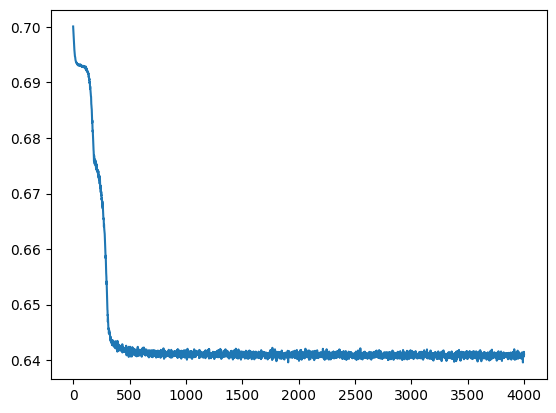

In [227]:
losslog = []
recons = []
xs = []
for epoch in tqdm(range(epochs)):
    for i, (images) in enumerate(train_loader):
        images = images.to(DEVICE)
        recon, mu, log_var = model(images)
        loss1, loss2, recon, x = model.compute_loss(images, recon, mu, log_var)
        with torch.no_grad() : recons.append(recon.detach()); xs.append(x.detach())
        loss = 0.1*loss1 + loss2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad() : losslog.append(loss.item())
    if epoch%300==0 : 
        tqdm.write(f'Epoch {epoch}, loss1 {loss1.item()}, loss2 {loss2.item()}')
plt.plot(losslog)

(0.0, 1.0)

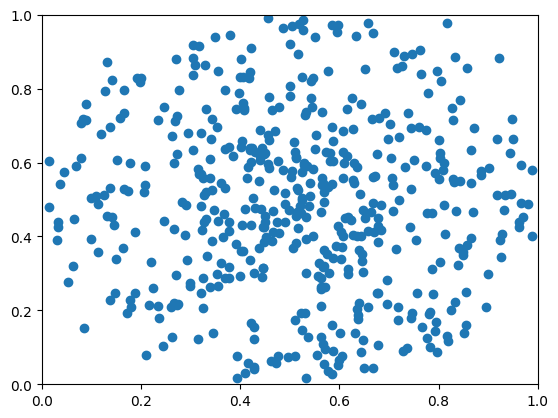

In [228]:
## generate new images by VAE
sample_zs = torch.randn(500, latent_dim).to('cuda:1')
model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs)
    generated_imgs = generated_imgs.cpu().numpy()
generated_imgs = np.array(generated_imgs)
plt.scatter(generated_imgs[:,0], generated_imgs[:,1])
plt.xlim(0.,1.)
plt.ylim(0.,1.)

In [229]:
gauss_std = 0.001/3
# pivot_indices = np.array([1,3,5,12,9,0,62,52,17,22])
# pivot_indices = np.arange(100)
pivot_images = dataset[:] # [(dataset[:]-0.5).norm(dim=-1) >= 0.1,:] # [ ::20000//200]
with torch.no_grad() : encodings = model.encoder(pivot_images.to(next(model.parameters()).device))[0].cpu()
pivot_images, encodings = pivot_images.squeeze(), encodings.squeeze()
pivot_images.shape, encodings.shape

(torch.Size([20000, 2]), torch.Size([20000, 2]))

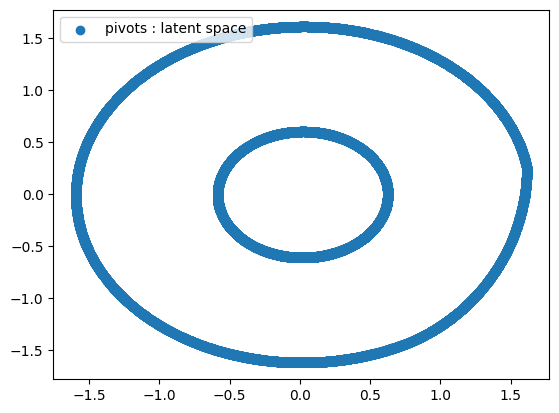

In [230]:
# visualizing the pivots
# plt.scatter(pivot_images[:,0], pivot_images[:,1], label='pivots : original space')
plt.scatter(encodings[:,0], encodings[:,1], label='pivots : latent space')
plt.legend();

(-3.0, 3.0)

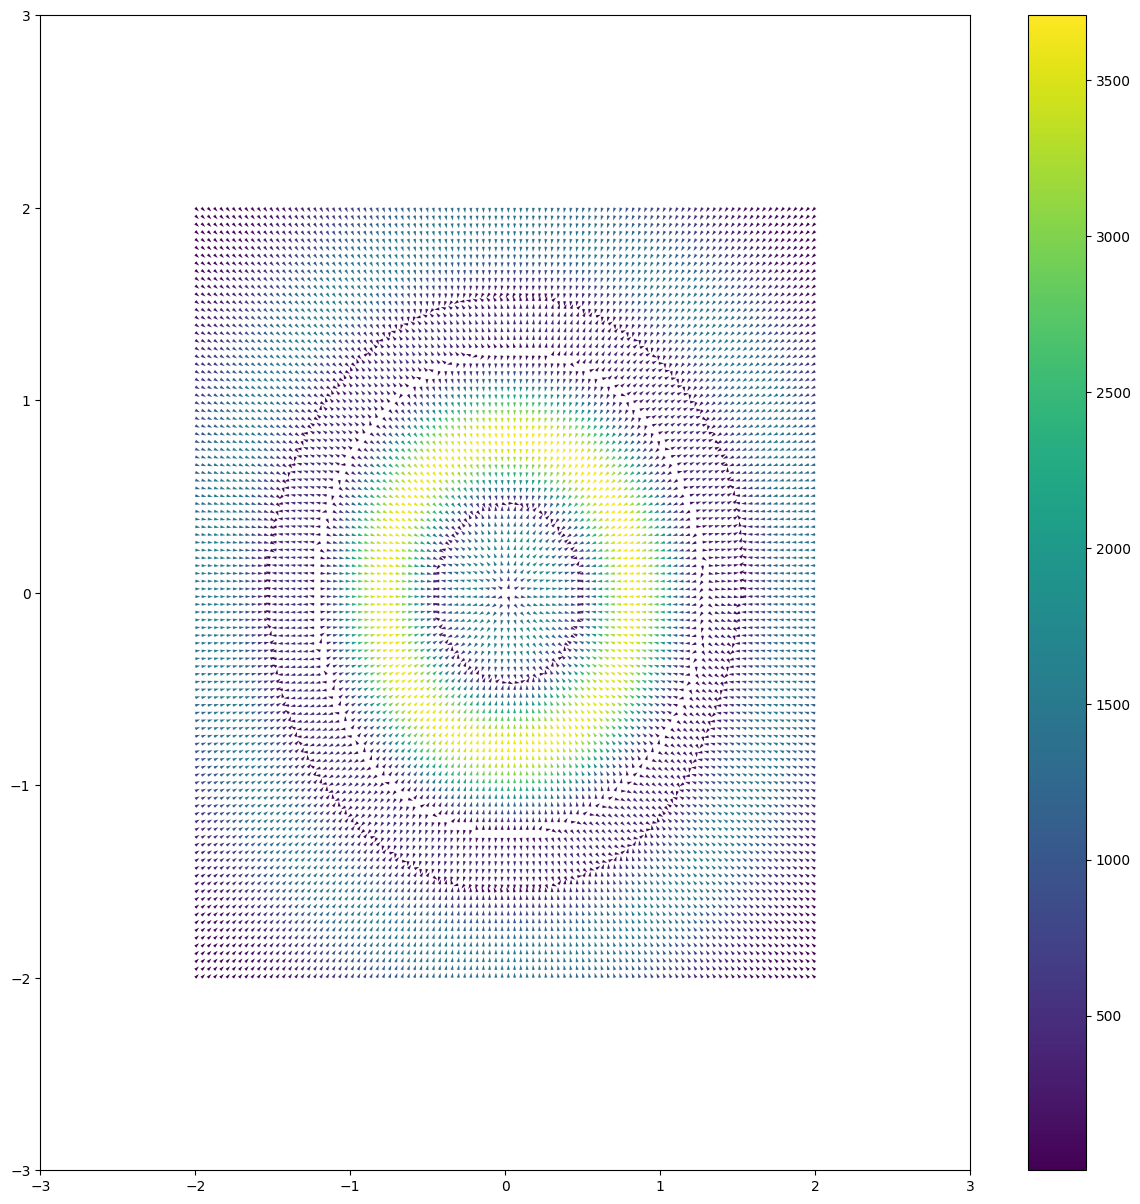

In [233]:
# potential function : sum of gaussians
def potential(z, encodings, sigma=gauss_std, pot=True) :
    z = z.view(-1, 1, encodings.shape[-1])
    ans = 0
    ans = torch.exp(-torch.norm(z-encodings, dim=-1)**2 / (2*sigma*sigma)).sum(-1)
    if pot : return -torch.log(ans)
    return ans

limit = 2.
x = torch.linspace(-limit, limit, 100)
y = torch.linspace(-limit, limit, 100)
z = torch.tensor([(a,b) for a in x for b in y])
z.requires_grad_()
u = potential(z, encodings, sigma=1/3, pot=False).sum()
grad = torch.autograd.grad(u, z)[0].detach()

y_pos = z[:,1].detach()
x_pos = z[:,0].detach()
x_dir = grad[:,0]
y_dir = grad[:,1]
norms = (x_dir**2 + y_dir**2)**0.5
plt.figure(figsize=(15,15))
plt.quiver(x_pos, y_pos, x_dir/norms, y_dir/norms ,norms, scale_units=None)
plt.colorbar()
plt.xlim(-3., 3.)
plt.ylim(-3., 3.)

In [234]:
torch.save(model, 'models/circle_gradExp.pt')